## Behavioral Cloning Project

### Dataframe from csv

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
data_file = '../../../Udacity-SDC-dataset/behavioral-cloning-data/driving_log.csv'
img_folder = '../../../Udacity-SDC-dataset/behavioral-cloning-data/'
df = pd.read_csv(data_file, skipinitialspace=True, usecols=[0, 1, 2, 3])
print(df.shape)
df.head(3)

(8036, 4)


,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0


### Visualize data distribution

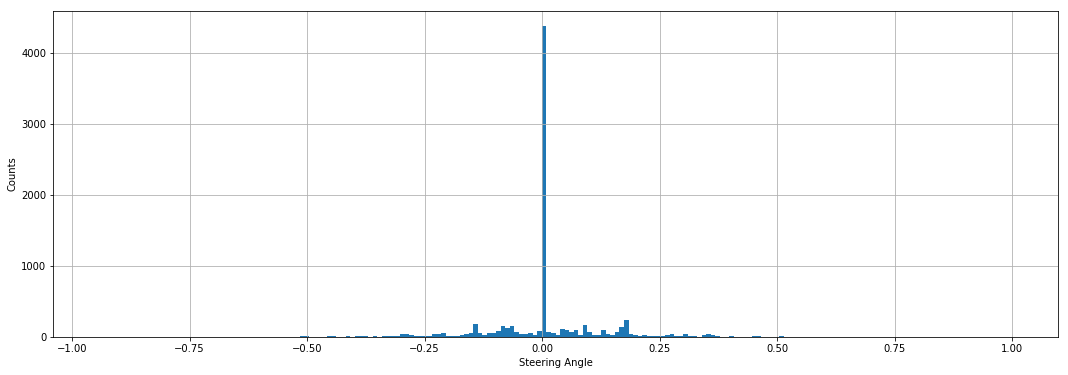

Total Data: 8036
Total Zeros: 4361


In [3]:
plt.figure(figsize=(18, 6))
df.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()
print("Total Data:", len(df.steering))
print("Total Zeros:",len(df[df.steering == 0]))

### Drop out zeros to balance data

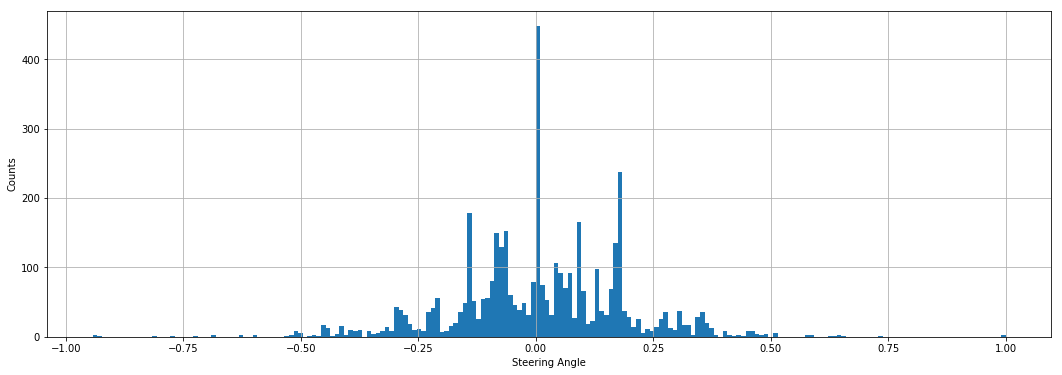

Total Data: 4111
Total Zeros: 436


In [4]:
zero_steering = df[df.steering == 0].sample(frac=0.9)
new_df = df.drop(zero_steering.index)
plt.figure(figsize=(18, 6))
new_df.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()
print("Total Data:", len(new_df.steering))
print("Total Zeros:",len(new_df[new_df.steering == 0]))

### Add more data by shifting left and right angles

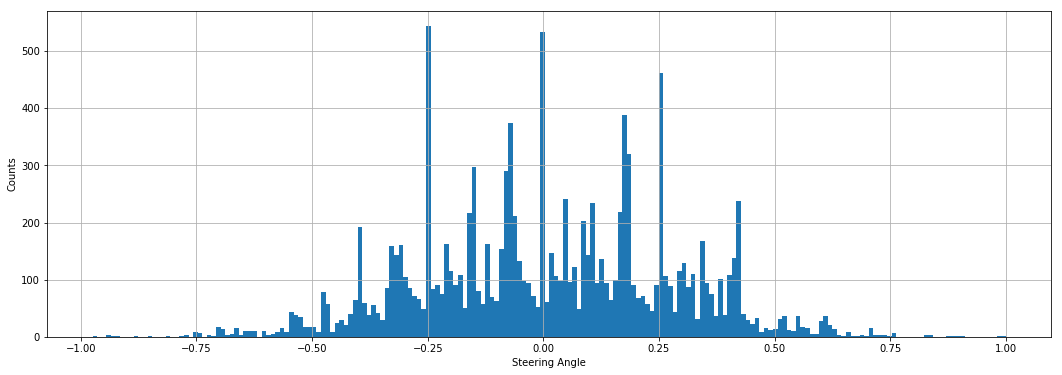

,image,steering
0,IMG/left_2016_12_01_13_31_14_904.jpg,0.25
1,IMG/center_2016_12_01_13_31_14_904.jpg,0.00
2,IMG/right_2016_12_01_13_31_14_904.jpg,-0.25


,image,steering
12330,IMG/left_2016_12_01_13_46_38_497.jpg,0.25
12331,IMG/center_2016_12_01_13_46_38_497.jpg,0.00
12332,IMG/right_2016_12_01_13_46_38_497.jpg,-0.25


Total Data: 12325
Total Zeros: 436


In [5]:
def steering_shift(df):
    data = []
    for i, row in new_df.iterrows():
        data.append({
            'image': row.left,
            'steering': row.steering + 0.25
        })
        data.append({
            'image': row.center,
            'steering': row.steering
        })
        data.append({
            'image': row.right,
            'steering': row.steering - 0.25
        })
    return pd.DataFrame(data=data, columns=['image', 'steering'])

shift_df = steering_shift(df)
outbound_steering = shift_df[abs(shift_df.steering) > 1]
shift_df = shift_df.drop(outbound_steering.index)

plt.figure(figsize=(18, 6))
shift_df.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()
display(shift_df.head(3))
display(shift_df.tail(3))
print("Total Data:", len(shift_df.steering))
print("Total Zeros:",len(shift_df[shift_df.steering == 0]))

### Flip steering angles and concat with original 

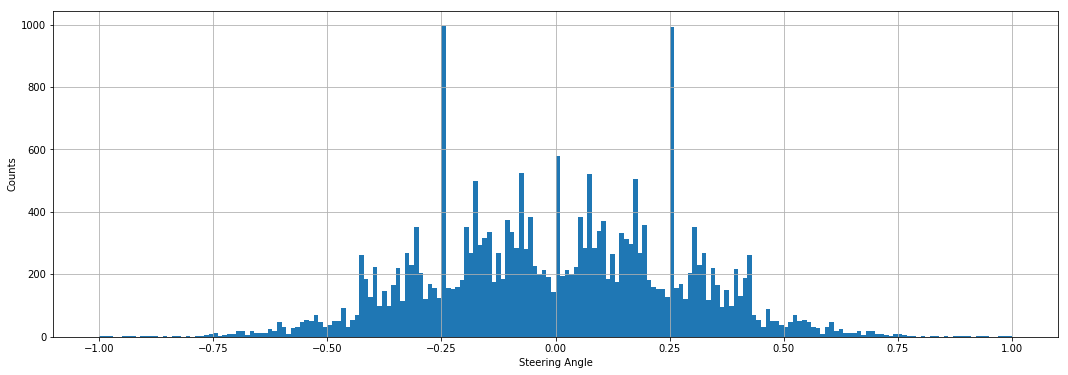

Total Data 24095
Total Zeros: 436


,image,steering,flipped
0,IMG/left_2016_12_01_13_31_14_904.jpg,0.25,False
1,IMG/center_2016_12_01_13_31_14_904.jpg,0.00,False
2,IMG/right_2016_12_01_13_31_14_904.jpg,-0.25,False


,image,steering,flipped
24092,IMG/right_2016_12_01_13_37_18_195.jpg,0.073418,True
24093,IMG/left_2016_12_01_13_41_05_055.jpg,-0.000356,True
24094,IMG/right_2016_12_01_13_37_59_737.jpg,0.073418,True


In [6]:
def steering_flip(df):
    df.loc[:, 'flipped'] = False
    new_df = df[df.steering != 0].sample(frac=0.99) 
    new_df.loc[:,'flipped'] = True
    new_df.loc[:, 'steering'] = new_df.steering * -1
    return pd.concat([df, new_df])

steering_combined = steering_flip(shift_df)
# reset index
steering_combined = steering_combined.reset_index(drop=True)

plt.figure(figsize=(18, 6))
steering_combined.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()
print("Total Data", len(steering_combined.steering))
print("Total Zeros:",len(steering_combined[steering_combined.steering == 0]))
display(steering_combined.head(3))
display(steering_combined.tail(3))

### Dropping out steering angles with more than 400 counts

,angles,counts
0,0.250000,868
1,-0.250000,866
2,0.000000,436
3,0.426582,237
4,0.176582,237


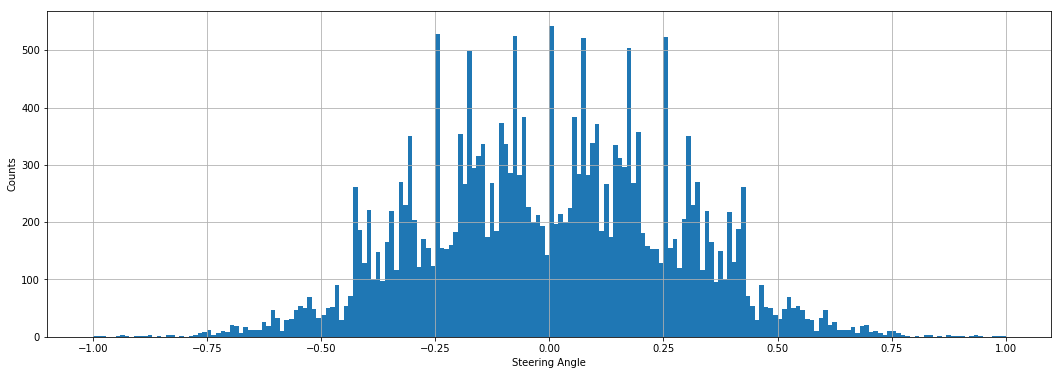

Total Data: 23125


In [7]:
count_max = 400
angles = steering_combined.steering.value_counts().index.tolist()
counts = steering_combined.steering.value_counts().tolist()

test = pd.DataFrame({
    'angles': angles,
    'counts': counts
})
display(test.head())

for i, row in test.iterrows():
    if row.counts > count_max:
        drop_frac = (row.counts-count_max)/(row.counts)
        drop_steering = steering_combined[steering_combined.steering == (row.angles)].sample(frac=drop_frac)
        steering_combined = steering_combined.drop(drop_steering.index)

plt.figure(figsize=(18, 6))
steering_combined.steering.hist(bins=200)
plt.xlabel('Steering Angle')
plt.ylabel('Counts')
plt.show()

# reset index
steering_combined = steering_combined.reset_index(drop=True)
print("Total Data:", len(steering_combined.steering))


### Save preprocessed data to new csv file

In [ ]:
steering_combined.to_csv('prep_driving_log.csv')

### Load the preprocessed csv file

In [6]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
%matplotlib inline
import cv2
data_file = 'prep_driving_log.csv'
img_folder = '../../../Udacity-SDC-dataset/behavioral-cloning-data/'
df = pd.read_csv(data_file, skipinitialspace=True, usecols=[1, 2, 3])
print(df.shape)
display(df.head(3))
display(df.tail(3))

(23125, 3)


,image,steering,flipped
0,IMG/left_2016_12_01_13_31_14_904.jpg,0.25,False
1,IMG/center_2016_12_01_13_31_14_904.jpg,0.00,False
2,IMG/right_2016_12_01_13_31_14_904.jpg,-0.25,False


,image,steering,flipped
23122,IMG/right_2016_12_01_13_37_18_195.jpg,0.073418,True
23123,IMG/left_2016_12_01_13_41_05_055.jpg,-0.000356,True
23124,IMG/right_2016_12_01_13_37_59_737.jpg,0.073418,True


### Image preprocess functions

In [4]:
def CropImage(image):
    return image[66:135, 0:319]

def ResizeImage(image):
    return cv2.resize(CropImage(image), (32, 14), cv2.INTER_AREA)

def RGB_to_S(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]

def FlipImage(image):
    return cv2.flip(image, 1)


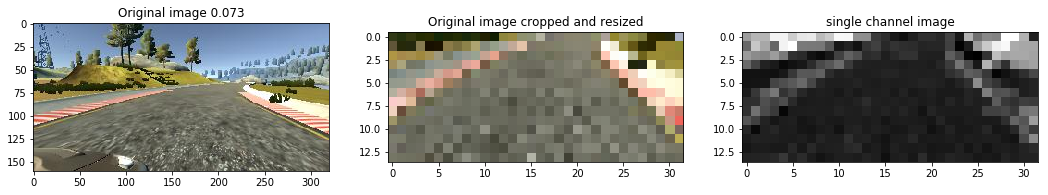

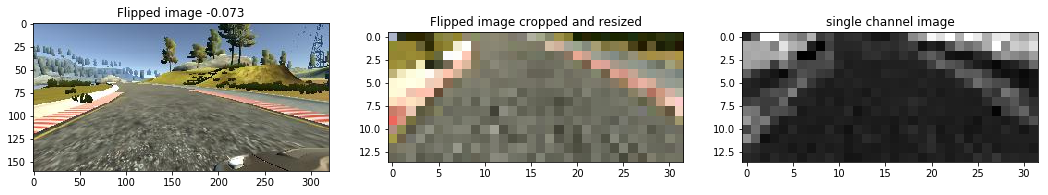

In [55]:
orig = mpimg.imread(img_folder + row.image)
resized_orig = ResizeImage(orig)
orig_s = RGB_to_S(resized_orig)
flip = FlipImage(orig)
resized_flip = ResizeImage(flip)
flip_s = RGB_to_S(resized_flip)

plt.figure(figsize=[18, 9])
plt.subplot(1, 3, 1)
plt.title('Original image {0:.3f}'.format(row.steering))
plt.imshow(orin)
plt.subplot(1, 3, 2)
plt.title('Original image cropped and resized')
plt.imshow(resized_orin)
plt.subplot(1, 3, 3)
plt.title('single channel image')
plt.imshow(orig_s.squeeze(),cmap='gray')

plt.figure(figsize=[18, 6])
plt.subplot(1, 3, 1)
plt.title('Flipped image {0:.3f}'.format(-row.steering))
plt.imshow(flip)
plt.subplot(1, 3, 2)
plt.title('Flipped image cropped and resized')
plt.imshow(resized_flip)
plt.subplot(1, 3, 3)
plt.title('single channel image')
plt.imshow(flip_s.squeeze(),cmap='gray')


### Resize and save as pickle (Will take a while)

In [11]:
img_folder = '../../../Udacity-SDC-dataset/behavioral-cloning-data/'

image_list = []
steering_list = []

for i, row in df.iterrows():
    img = mpimg.imread(img_folder + row.image)
    if (row.flipped):
        img = FlipImage(img)
    img = ResizeImage(img)
    img = RGB_to_S(img)
    image_list.append(img)
    steering_list.append(row.steering)

image_list = np.asarray(image_list)
steering_list = np.asarray(steering_list)
image_list = image_list.reshape(image_list.shape + (1,))
print(image_list.shape)
print(steering_list.shape)

(23125, 14, 32, 1)
(23125,)


In [ ]:
import pickle
train_file = 'train.p'

pickle.dump({
        "features" : image_list,
        "labels" : steering_list
    }, open(train_file, "wb" ) )
print('train data saved')

## Start from here since we have preprocessed all data and store as pickle file

### Load pickle file

In [12]:
import pickle
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
train_file = 'train.p'

with open(train_file, mode='rb') as f:
    train = pickle.load(f)

X_train, y_train = train['features'], train['labels']

### Split training set and validation set

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=0, test_size=0.15)
print('Images for training: ',X_train.shape[0])
print('Images for validation: ',X_val.shape[0])

Images for training:  19656
Images for validation:  3469


### Network Architecture

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 14, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 32, 1)         2         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 8, 1)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 8, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


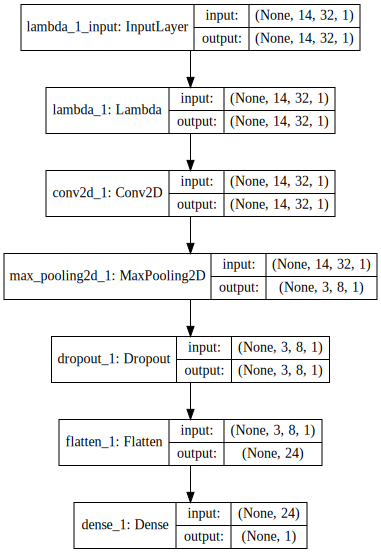

In [3]:
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = Sequential([
Lambda(lambda x: x/127.5-1.,input_shape=(14, 32, 1)),
Conv2D(1, (1, 1), padding='valid', input_shape=(14, 32, 1), activation='relu'),
MaxPooling2D((4, 4),(4, 4),'valid'),
Dropout(0.25),
Flatten(),
Dense(1)
])
model.summary()
SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

### Start training

In [4]:
%%time
batch_size = 128
epochs = 30

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=2, min_delta=0.0001, 
                                            verbose=0, mode='auto')

model.compile(loss='mse',optimizer=Adam(lr=1e-3))
history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    epochs=epochs,verbose=2, 
                    validation_data=(X_val, y_val),
                    callbacks=[earlyStopping])

Train on 19656 samples, validate on 3469 samples
Epoch 1/30
1s - loss: 0.0860 - val_loss: 0.0651
Epoch 2/30
0s - loss: 0.0633 - val_loss: 0.0455
Epoch 3/30
0s - loss: 0.0472 - val_loss: 0.0360
Epoch 4/30
0s - loss: 0.0402 - val_loss: 0.0335
Epoch 5/30
0s - loss: 0.0373 - val_loss: 0.0327
Epoch 6/30
0s - loss: 0.0367 - val_loss: 0.0323
Epoch 7/30
0s - loss: 0.0357 - val_loss: 0.0318
Epoch 8/30
0s - loss: 0.0356 - val_loss: 0.0316
Epoch 9/30
0s - loss: 0.0353 - val_loss: 0.0315
Epoch 10/30
0s - loss: 0.0354 - val_loss: 0.0313
Epoch 11/30
0s - loss: 0.0356 - val_loss: 0.0315
Epoch 12/30
0s - loss: 0.0354 - val_loss: 0.0314
Epoch 13/30
0s - loss: 0.0351 - val_loss: 0.0311
Epoch 14/30
0s - loss: 0.0352 - val_loss: 0.0316
Epoch 15/30
0s - loss: 0.0352 - val_loss: 0.0313
Epoch 16/30
0s - loss: 0.0354 - val_loss: 0.0315
CPU times: user 9.94 s, sys: 1.04 s, total: 11 s
Wall time: 8.84 s


### Plot training history

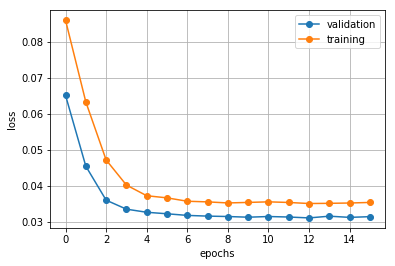

In [5]:
plt.plot(history.epoch,history.history['val_loss'],'-o',label='validation')
plt.plot(history.epoch,history.history['loss'],'-o',label='training')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

### Save models

In [6]:
model.save("model.h5")

with open("model.json", "w") as json_file:
  json_file.write(model.to_json())

print("Model Saved.")

Model Saved.


### Load the Model

In [1]:
from keras.models import Sequential, Model
from keras.models import load_model, model_from_json
import json

with open('model.json', 'r') as json_file:
    model = model_from_json(json_file.read())
model.load_weights('model.h5')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 14, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 32, 1)         2         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 8, 1)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 8, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


### Visualize the attention map

In [2]:
from vis.visualization import visualize_saliency, overlay, visualize_cam
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
%matplotlib inline

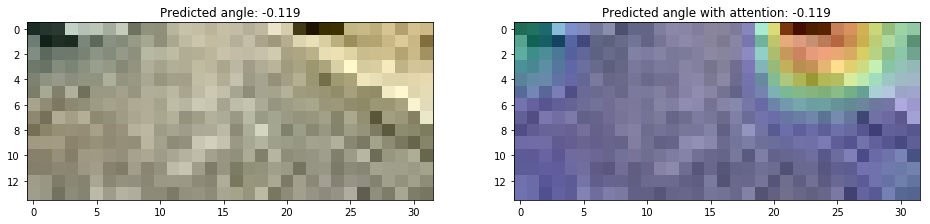

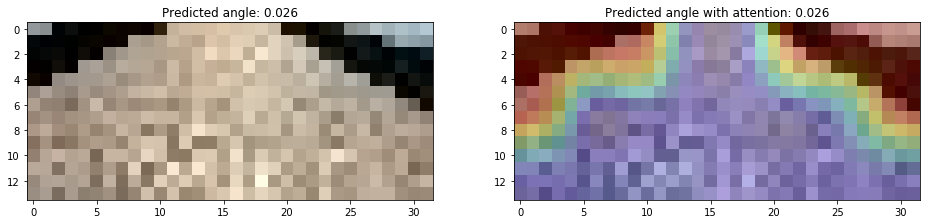

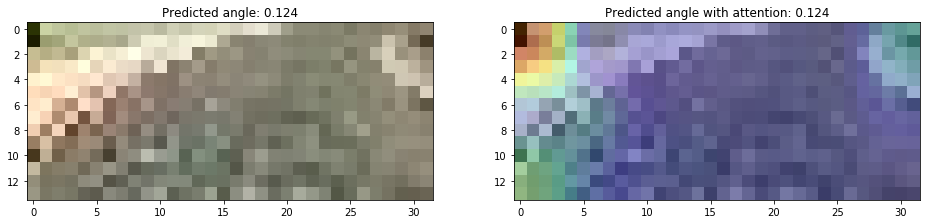

CPU times: user 1.13 s, sys: 832 ms, total: 1.96 s
Wall time: 1.16 s


In [5]:
%%time

img1 = 'rgb/2017_07_16_14_11_11_826.jpg'
img2 = 'rgb/2017_07_16_14_11_14_840.jpg'
img3 = 'rgb/2017_07_16_14_11_37_035.jpg'
img_list = [img1, img2, img3]


for img in img_list:
    img_rgb = mpimg.imread(img)
    S_img = RGB_to_S(img_rgb)
    img_input = np.expand_dims(img_to_array(S_img), axis=0)
    #heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, seed_input=img_input, grad_modifier=None)
    heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, seed_input=img_input, grad_modifier='small_values')
    overlay_img = overlay(img_rgb, heatmap, alpha=0.7)
    pred = model.predict(img_input)[0][0]
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Predicted angle: {0:.3f}'.format(pred))
    plt.imshow(img_rgb)
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted angle with attention: {0:.3f}'.format(pred))
    plt.imshow(overlay_img)
    plt.show()


In [ ]:
'''
images = os.listdir("rgb/")

for img in images:
    img_rgb = mpimg.imread('rgb/' + img)
    S_img = RGB_to_S(img_rgb)
    img_input = np.expand_dims(img_to_array(S_img), axis=0)
    heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, 
                            seed_input=img_input, grad_modifier='negate')
    overlay_img = overlay(img_rgb, heatmap, alpha=0.7)
    #im.save('heatmap/{}.jpg'.format(img))
    mpimg.imsave(('heatmap/{}.png'.format(img)), overlay_img)
    #mpimg.imsave('heatmap/test.jpg', heatmap)
    #
'''  